In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from keras.optimizers import Adam


In [3]:

import os
from sklearn.model_selection import train_test_split
#import os
from sklearn.model_selection import train_test_split

import os
from sklearn.model_selection import train_test_split



In [4]:
# Define paths to your dataset directories
dataset_dir = 'D:/COVID-19_Radiography_Dataset'

# List all images in each class directory
normal_dir = os.path.join(dataset_dir, 'normal')
covid_dir = os.path.join(dataset_dir, 'covid')
pneumonia_dir = os.path.join(dataset_dir, 'viral_pneumonia')

normal_files = [os.path.join(normal_dir, file) for file in os.listdir(normal_dir) if file.endswith('.png')]
covid_files = [os.path.join(covid_dir, file) for file in os.listdir(covid_dir) if file.endswith('.png')]
pneumonia_files = [os.path.join(pneumonia_dir, file) for file in os.listdir(pneumonia_dir) if file.endswith('.png')]

# Split the dataset for each class into training and testing sets
normal_train, normal_test = train_test_split(normal_files, test_size=0.2, random_state=42)
covid_train, covid_test = train_test_split(covid_files, test_size=0.2, random_state=42)
pneumonia_train, pneumonia_test = train_test_split(pneumonia_files, test_size=0.2, random_state=42)

# Combine the training and testing sets for each class
train_files = normal_train + covid_train + pneumonia_train
test_files = normal_test + covid_test + pneumonia_test

# Create labels for the training and testing sets
train_labels = ['normal'] * len(normal_train) + ['covid'] * len(covid_train) + ['pneumonia'] * len(pneumonia_train)
test_labels = ['normal'] * len(normal_test) + ['covid'] * len(covid_test) + ['pneumonia'] * len(pneumonia_test)

print("Number of training samples:", len(train_files))
print("Number of testing samples:", len(test_files))



Number of training samples: 3424
Number of testing samples: 857


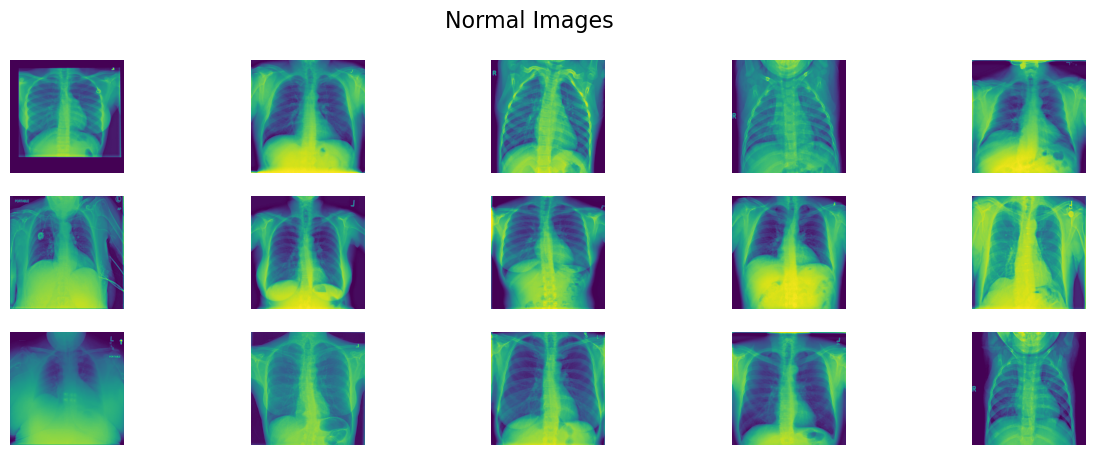

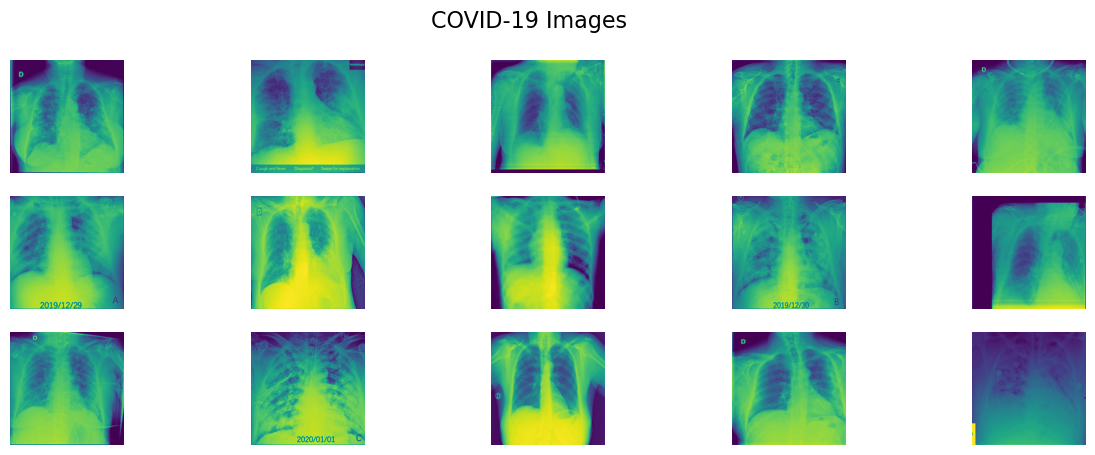

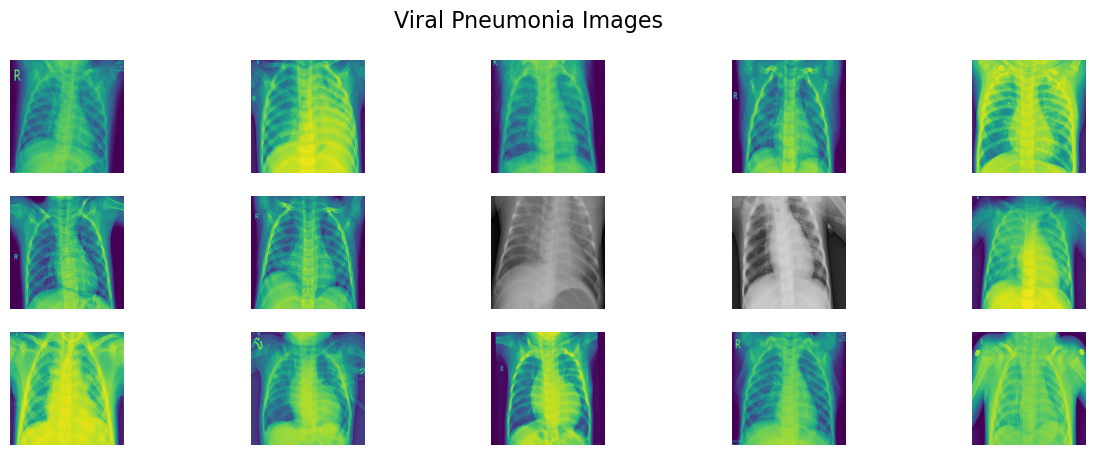

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define a function to display images
def display_images(image_files, title):
    plt.figure(figsize=(15, 5))
    plt.suptitle(title, fontsize=16)
    for i in range(15):
        plt.subplot(3, 5, i + 1)
        img = mpimg.imread(image_files[i])
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display 15 images from each class
display_images(normal_files, 'Normal Images')
display_images(covid_files, 'COVID-19 Images')
display_images(pneumonia_files, 'Viral Pneumonia Images')


In [6]:
# Image dimensions
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)

# Number of epochs
epochs = 30
batch_size = 32

# Data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Load images from the x-ray_images directory and split into training and validation sets
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)



Found 3426 images belonging to 3 classes.
Found 855 images belonging to 3 classes.


In [7]:
# Load the VGG16 model without the top layer (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the convolutional base
base_model.trainable = False

# Flatten the output of VGG16 and add a fully connected layer
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(3, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // batch_size
)

Epoch 1/30


C:\ProgramData\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


107/107 ━━━━━━━━━━━━━━━━━━━━ 743s 7s/step - accuracy: 0.6306 - loss: 0.8621 - val_accuracy: 0.7356 - val_loss: 0.7386
Epoch 2/30
  1/107 ━━━━━━━━━━━━━━━━━━━━ 9:57 6s/step - accuracy: 0.8438 - loss: 0.3959

C:\ProgramData\anaconda3\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.8438 - loss: 0.3959 - val_accuracy: 0.5217 - val_loss: 1.2867
Epoch 3/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 804s 7s/step - accuracy: 0.8693 - loss: 0.3893 - val_accuracy: 0.7716 - val_loss: 0.7711
Epoch 4/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 1.0000 - loss: 0.1298 - val_accuracy: 0.7391 - val_loss: 0.7464
Epoch 5/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 775s 7s/step - accuracy: 0.9072 - loss: 0.3032 - val_accuracy: 0.7752 - val_loss: 0.7385
Epoch 6/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.9062 - loss: 0.2649 - val_accuracy: 0.6957 - val_loss: 1.0243
Epoch 7/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 767s 7s/step - accuracy: 0.9225 - loss: 0.2669 - val_accuracy: 0.7776 - val_loss: 0.6960
Epoch 8/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9375 - loss: 0.2206 - val_accuracy: 0.7826 - val_loss: 0.4187
Epoch 9/30
107/107 ━━━━━━━━━━━━━━━━━━━━ 782s 7s/step - accuracy: 0.9266 - loss: 0.2474 - val_accuracy: 0

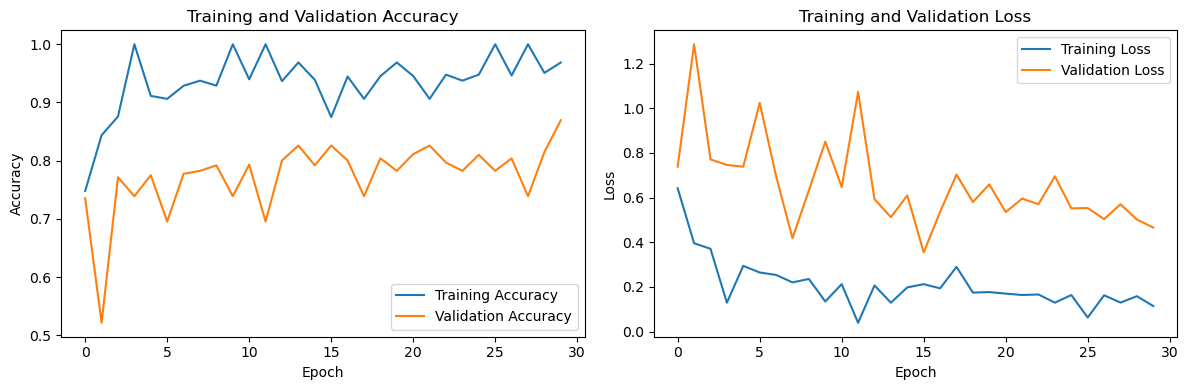

In [9]:
# Plot accuracy and loss curves for training and validation
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# Define the data generator for test data
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)

# Load images from the dataset directory for testing
test_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4281 images belonging to 3 classes.


In [11]:
# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# True labels
y_true = test_generator.classes

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

134/134 ━━━━━━━━━━━━━━━━━━━━ 792s 6s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2795
           1       0.86      0.81      0.83       914
           2       0.99      0.85      0.91       572

    accuracy                           0.93      4281
   macro avg       0.93      0.88      0.90      4281
weighted avg       0.93      0.93      0.93      4281

Confusion Matrix:
[[2752   38    5]
 [ 177  736    1]
 [   8   78  486]]


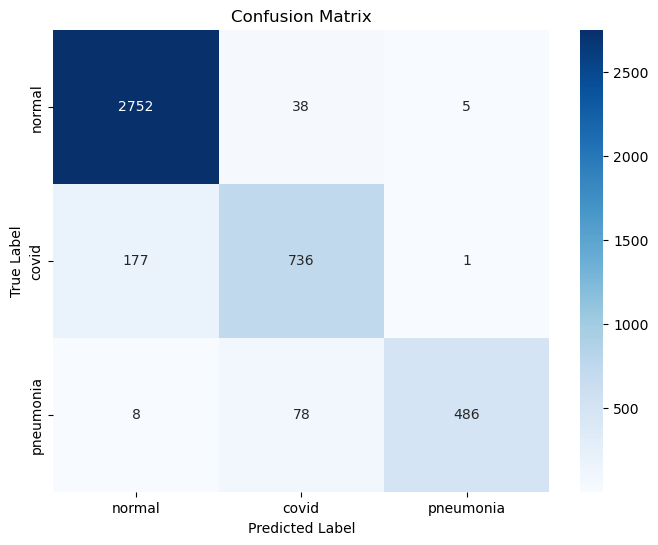

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['normal', 'covid', 'pneumonia'], 
            yticklabels=['normal', 'covid', 'pneumonia'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
